In [3]:
import tensorflow as tf
import numpy as np
import deepxde as dde

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [65]:
# Set the data type 
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi,dtype=DTYPE)

def fun_u_0(x,y):
    return tf.exp(-5*(x**2 + y**2))

def fun_u_b(t,x):
    n = x.shape[0]
    return tf.zeros((n,1),dtype = DTYPE)

def f(x,y,t):
    return (-100*x**2-100*y**2)*tf.exp(-20*t)*tf.exp(-5*(x**2+y**2))

def residual(u_t,u_xx, u_yy,x,y,t):
    
    f_val = f(x,y,t)
    f_u = u_t - u_xx - u_yy - f_val

    return f_u

class PhysicsInformedNN:
    def __init__(self, lb, ub, layers, u0, x0, X):

        self.lb = lb
        self.ub = ub
                
        self.layers = layers

        self.u0 = u0
        self.X0 = x0

        self.X = X

        self.model = self.initialize_NN(layers)

    def initialize_NN(self,layers):
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(layers[0]))
        scaling_layer = tf.keras.layers.Lambda(
            lambda x: 2.0*(x-self.lb)/(self.ub-self.lb)-1.0)
        model.add(scaling_layer)
        num_layers = len(layers)
        for i in range(1,num_layers-2):
            model.add(tf.keras.layers.Dense(layers[i],
                                            activation=tf.keras.activations.get('tanh'),
                                            kernel_initializer='glorot_normal'))
        model.add(tf.keras.layers.Dense(layers[-1]))

        return model
    

    def loss(self, X, X0, u0):
        u_pred = self.model(X0)
        
        loss = tf.reduce_mean(tf.square(u0-u_pred))

        r1 = self.get_residual(X)

        phi_ru = tf.reduce_mean(tf.square(r1))

        loss += phi_ru

        return loss
    
    def get_residual(self,X):
        with tf.GradientTape(persistent=True) as tape:
            x = X[:,0:1]
            y = X[:,1:2]
            t = X[:,2:3]

            tape.watch(x)
            tape.watch(y)
            tape.watch(t)

            u = self.model(tf.stack([x[:,0],y[:,0],t[:,0]], axis=1))


            u_t = tape.gradient(u,t)
            u_x = tape.gradient(u,x)
            u_xx = tape.gradient(u_x,x)
            u_y = tape.gradient(u,y)
            u_yy = tape.gradient(u_y,y)

        del tape
        
        f_u = residual(u_t,u_xx,u_yy, x, y, t)

        return f_u
    
    def loss_gradient(self,X,X0,u0, v0):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss(self, X, X0, u0, v0)
            g = tape.gradient(loss, self.model.trainable_variables)

        del tape
        return loss, g

    # def optimization_step(self, cor=50, tol=1.0  * np.finfo(float).eps,  iter=50000, fun=50000, ls=50):
    #     def time_step():
    #         loss = self.loss(self.X, self.X0, self.u0)
    #         return loss
    #     variables = self.model.trainable_variables
    #     dde.optimizers.config.set_LBFGS_options(maxcor=cor, ftol=tol,  maxiter=iter, maxfun=fun, maxls=ls)
    #     dde.optimizers.tfp_optimizer.lbfgs_minimize(variables, time_step)
    #     return loss


In [66]:
import scipy

In [67]:
layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 1]

N_0 = 50
N_b = 50
N_r = 10000

tmin = 0.
tmax = 1.
xmin = -2.
xmax = 2.
ymin = -2
ymax = 2
# Lower bounds
lb = tf.constant([tmin, xmin, ymin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax, ymax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
y_0 = tf.random.uniform((N_0,1), lb[2], ub[2], dtype=DTYPE)
X_0 = tf.concat([x_0, y_0 , t_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0, y_0)

# Boundary data
t_b1 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b1 = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
y_b1 = tf.ones((N_0,1), dtype=DTYPE)*lb[2]
X_b1 = tf.concat([x_b1, y_b1 , t_b1], axis=1)

t_b2 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b2 = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
y_b2 = tf.ones((N_0,1), dtype=DTYPE)*ub[2]
X_b2 = tf.concat([x_b2, y_b2 , t_b2], axis=1)

t_b3 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
y_b3 = lb[2] + (ub[2] - lb[2]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
x_b3 = tf.ones((N_0,1), dtype=DTYPE)*lb[1]
X_b3 = tf.concat([x_b3, y_b3 , t_b3], axis=1)

t_b4 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
y_b4 = lb[2] + (ub[2] - lb[2]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
x_b4 = tf.ones((N_0,1), dtype=DTYPE)*ub[1]
X_b4 = tf.concat([x_b4, y_b4 , t_b4], axis=1)
# Evaluate boundary condition at (t_b,x_b)
u_b1 = fun_u_b(t_b1, x_b1)
u_b2 = fun_u_b(t_b2, x_b2)
u_b3 = fun_u_b(t_b3, y_b3)
u_b4 = fun_u_b(t_b4, y_b4)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
y_r = tf.random.uniform((N_r,1), lb[2], ub[2], dtype=DTYPE)
X_r = tf.concat([ x_r, y_r, t_r], axis=1)

# Collect boundary and inital data in lists
X_data = tf.concat([X_0, X_b1, X_b2, X_b3, X_b4],0)
u_data = tf.concat([u_0, u_b1, u_b2, u_b3, u_b4],0)


In [68]:
model = PhysicsInformedNN(xmin, xmax, layers, u_data, X_data, X_r)

In [69]:
def time_step():
        loss = model.loss(model.X, model.X0, model.u0)
        return loss

In [70]:
variables = model.model.trainable_variables

In [71]:
cor=50
tol=1.0  * np.finfo(float).eps
iter=50000
fun=50000
ls=50

In [72]:
dde.optimizers.config.set_LBFGS_options(maxcor=cor, ftol=tol,  maxiter=iter, maxfun=fun, maxls=ls)

In [73]:
dde.optimizers.tfp_optimizer.lbfgs_minimize(variables, time_step)

LBfgsOptimizerResults(converged=<tf.Tensor: shape=(), dtype=bool, numpy=False>, failed=<tf.Tensor: shape=(), dtype=bool, numpy=True>, num_iterations=<tf.Tensor: shape=(), dtype=int32, numpy=926>, num_objective_evaluations=<tf.Tensor: shape=(), dtype=int32, numpy=2511>, position=<tf.Tensor: shape=(2621,), dtype=float32, numpy=
array([ 0.43417025, -0.59505403, -0.5457374 , ..., -0.4618492 ,
        0.539294  ,  0.33057088], dtype=float32)>, objective_value=<tf.Tensor: shape=(), dtype=float32, numpy=1.2037793e-06>, objective_gradient=<tf.Tensor: shape=(2621,), dtype=float32, numpy=
array([ 1.8343953e-06, -4.0454361e-06, -2.9255662e-06, ...,
       -5.4411385e-06, -5.1747247e-06,  3.3964170e-06], dtype=float32)>, position_deltas=<tf.Tensor: shape=(50, 2621), dtype=float32, numpy=
array([[ 6.75916672e-05, -2.35795975e-04, -2.14695930e-04, ...,
        -2.50637531e-05, -2.43782997e-05,  3.51428986e-04],
       [ 6.41047955e-05, -9.47713852e-06,  6.98566437e-05, ...,
        -2.31951475e-04, 

In [29]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random

In [30]:
x = X_r[:,0]
y = X_r[:,1]
t = X_r[:,2]
z = model.model(model.X)

In [74]:
x = np.arange(xmin,xmax,0.01)
y = np.arange(ymin,ymax,0.01)
x, y = np.meshgrid(x, y)


In [87]:
t = np.ones(x.shape)*0.4

In [88]:
xn = tf.convert_to_tensor(np.transpose([np.ravel(x)]))
yn = tf.convert_to_tensor(np.transpose([np.ravel(y)]))
tn = tf.convert_to_tensor(np.transpose([np.ravel(t)]))
X = tf.concat([xn,yn,tn],1)

In [89]:
z = model.model(X)
z = z.numpy()
z = z.reshape(x.shape)

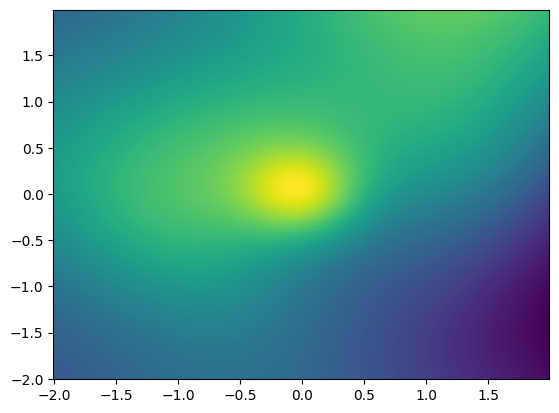

In [90]:
fig, ax = plt.subplots()
ax.pcolormesh(x, y, z)


In [54]:
import h5py